# Load the data and upload to HF

In [1]:
from datasets import Dataset
from datasets import load_dataset
from glob import glob
import pandas as pd
import numpy as np

In [2]:
configuration = glob("*/*/*")
energy = []
latency_stats = []
throughput = []
for c in configuration:

    pwr = pd.read_csv(c+"/pwr.csv")
    if c.startswith("a100"):
        pwr = pwr[0::4]
    elif c.startswith("a6000"):
        pwr = pwr[0::8]
    elif c.startswith("4090"):
        pass
    else:
        assert(1==0)

    pwr = pwr[-301:]
    t = pd.to_datetime(pwr['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    δt = (np.diff(t)/1e9).astype("float")
    P = np.array(pwr[' power.draw [W]'][:-1].str.replace(' W', '')).astype(float)
    energy.append(np.sum(δt*P))

    tput = pd.read_csv(c+"/tput.csv").to_numpy()[0][2:]
    p0 = pd.read_csv(c+"/total_p0.csv").to_numpy()[0][2:]
    p50 = pd.read_csv(c+"/total_p50.csv").to_numpy()[0][2:]
    p90 = pd.read_csv(c+"/total_p90.csv").to_numpy()[0][2:]
    p100 = pd.read_csv(c+"/total_p100.csv").to_numpy()[0][2:]
    latency = np.vstack([p0,p50,p90,p100])

    while len(tput) <3:
        tput = np.hstack([tput,np.nan])
        latency = np.hstack([latency,[[np.nan],[np.nan],[np.nan],[np.nan]]])

    latency_stats.append(latency)
    throughput.append(tput)

In [3]:
dataset = Dataset.from_dict({
    'configuration': configuration,
    'energy': energy,
    'latency_stats': latency_stats,
    'throughput': throughput,
})

In [4]:
dataset.push_to_hub("danjacobellis/model_triplets",split='train')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/danjacobellis/model_triplets/commit/616a29a312800a749c6915b2a41739128cc1d396', commit_message='Upload dataset', commit_description='', oid='616a29a312800a749c6915b2a41739128cc1d396', pr_url=None, pr_revision=None, pr_num=None)

# Plot

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = load_dataset("danjacobellis/model_triplets",split='train').with_format("numpy")

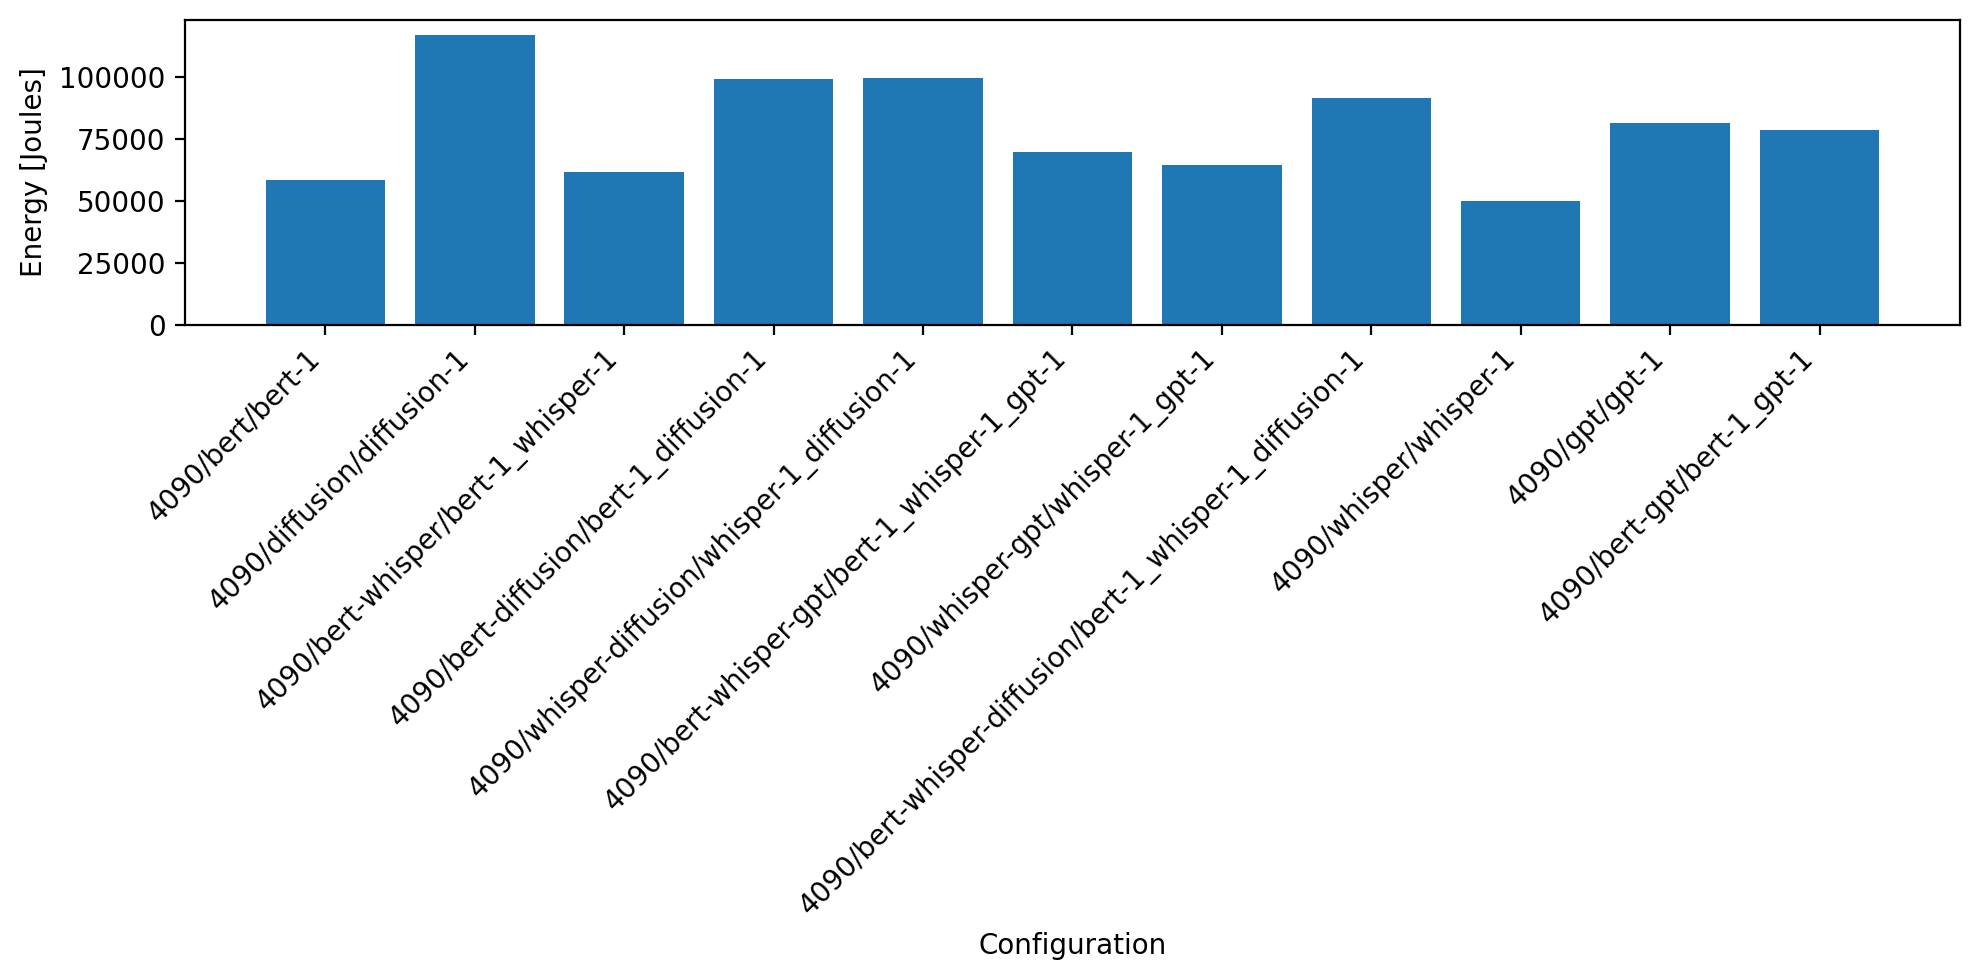

In [3]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.bar(dataset['configuration'][0:11], dataset['energy'][0:11])
ax.set_ylabel('Energy [Joules]')
ax.set_xlabel('Configuration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

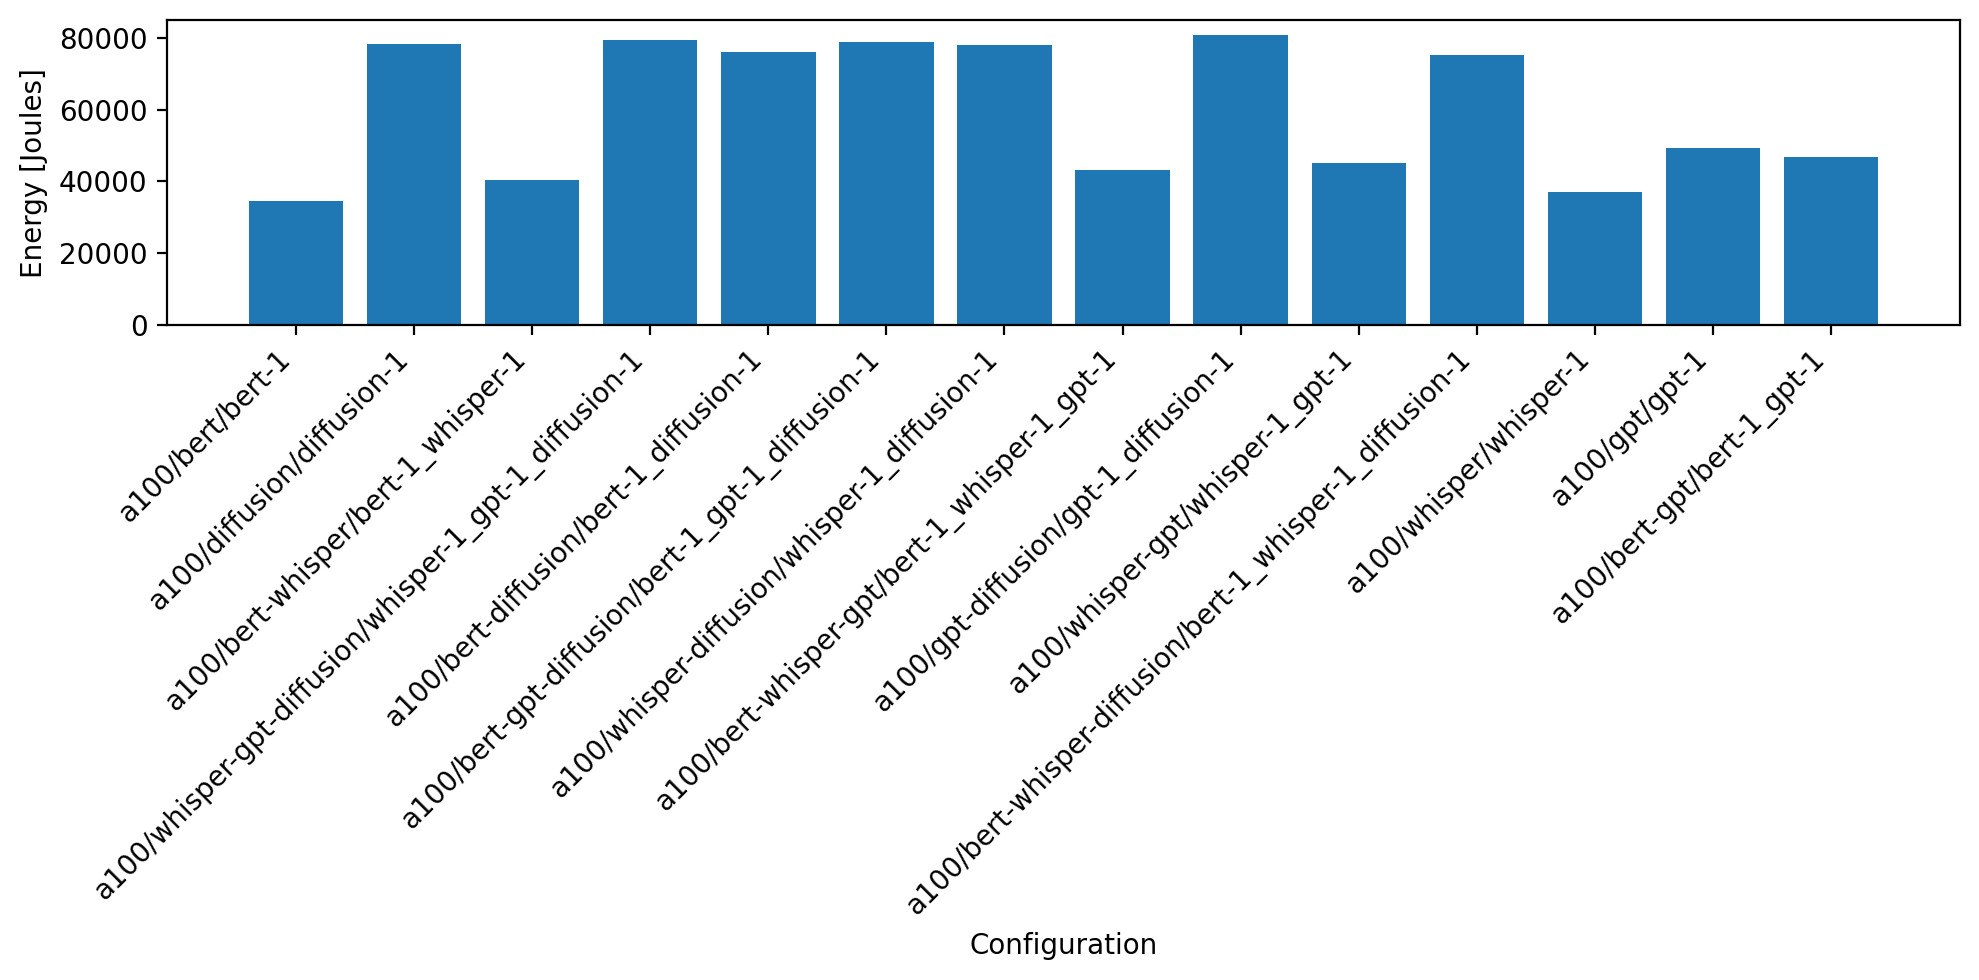

In [4]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.bar(dataset['configuration'][11:], dataset['energy'][11:])
ax.set_ylabel('Energy [Joules]')
ax.set_xlabel('Configuration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

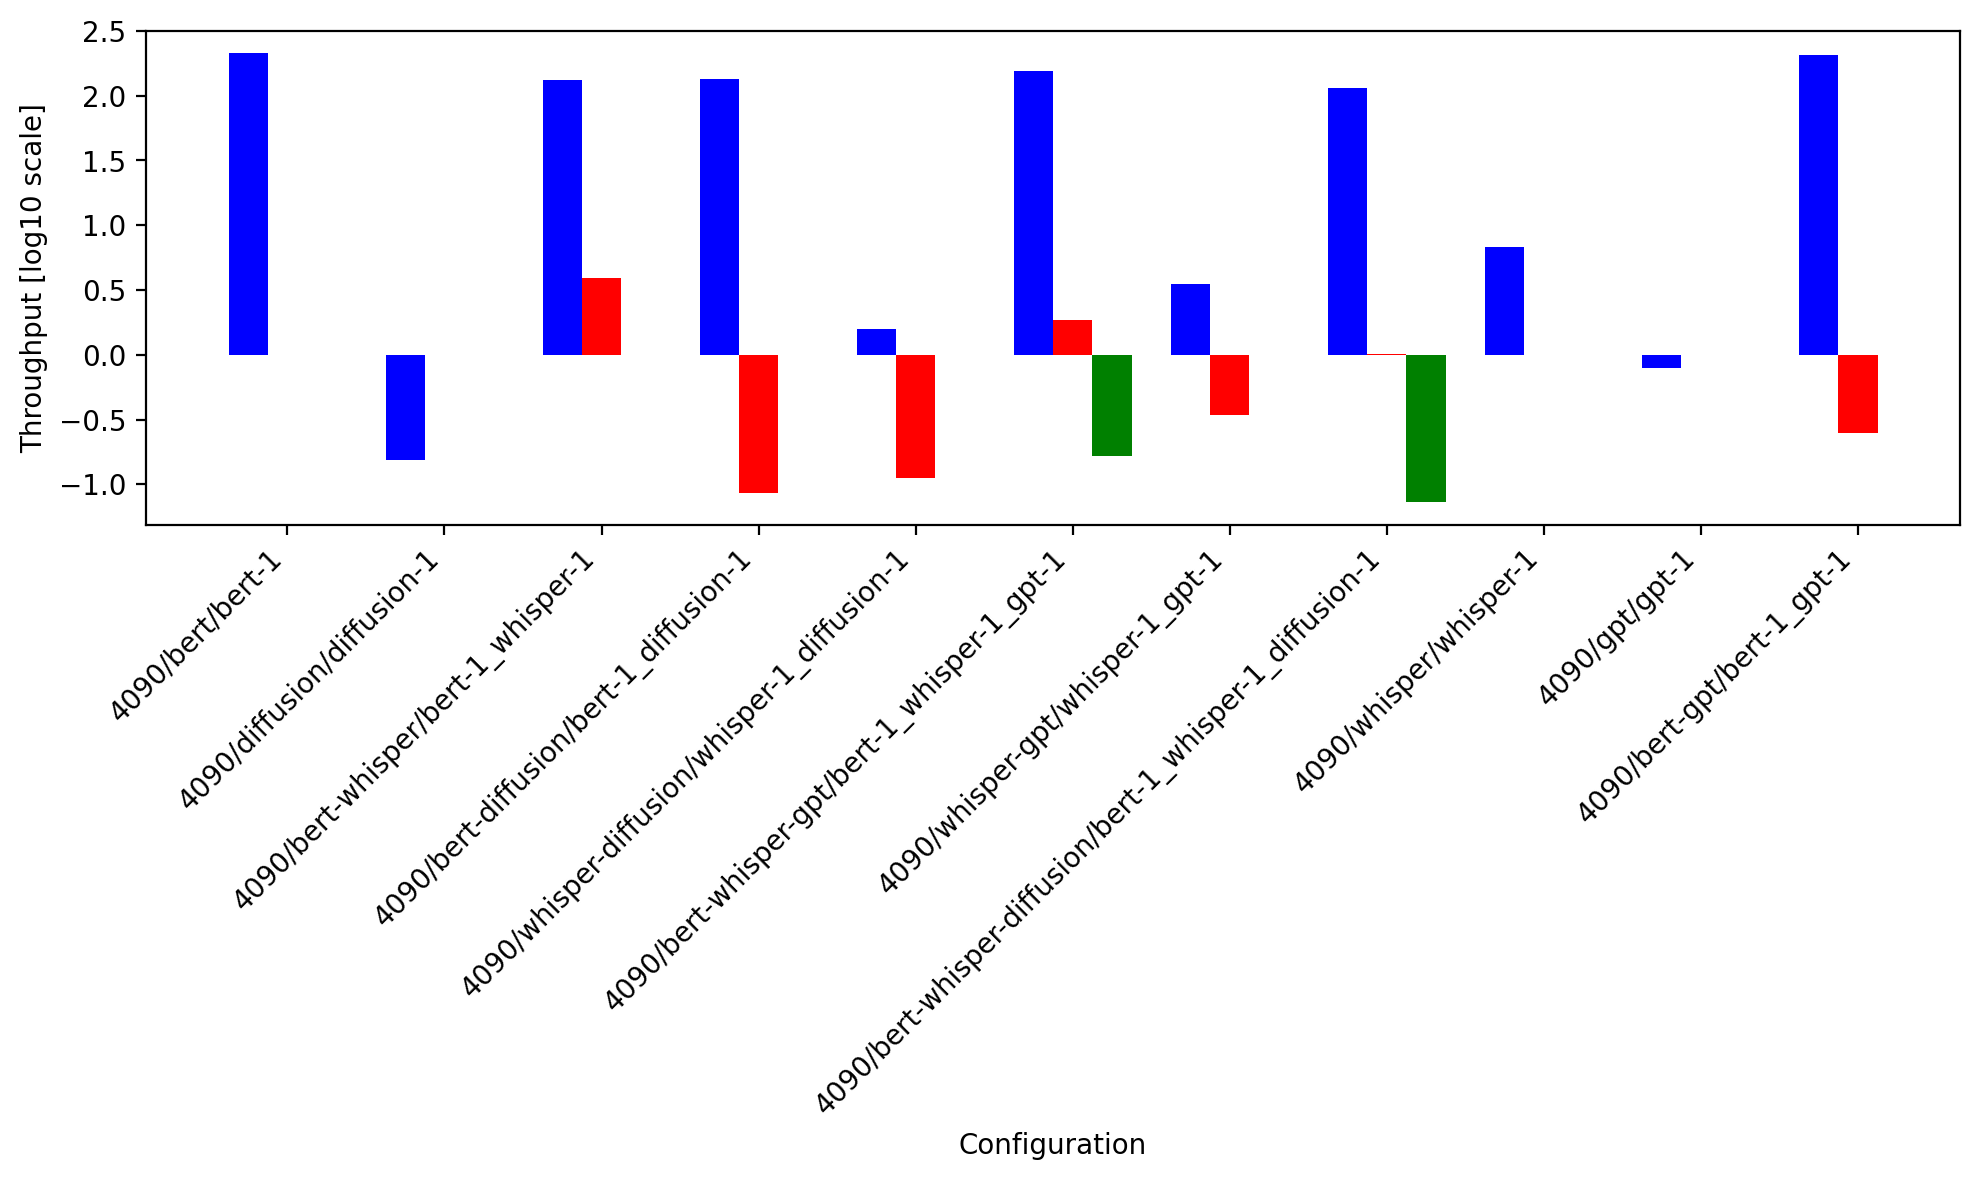

In [5]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
width = 0.25 
x = np.arange(len(dataset['configuration'][0:11]))
ax.bar(x - width, np.log10(dataset['throughput'][0:11, 0]), width, label='First model', color='blue')
ax.bar(x, np.log10(dataset['throughput'][0:11, 1]), width, label='Second model', color='red')
ax.bar(x + width, np.log10(dataset['throughput'][0:11, 2]), width, label='Third model', color='green')
ax.set_ylabel('Throughput [log10 scale]')
ax.set_xlabel('Configuration')
ax.set_xticks(x)
ax.set_xticklabels(dataset['configuration'][0:11])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

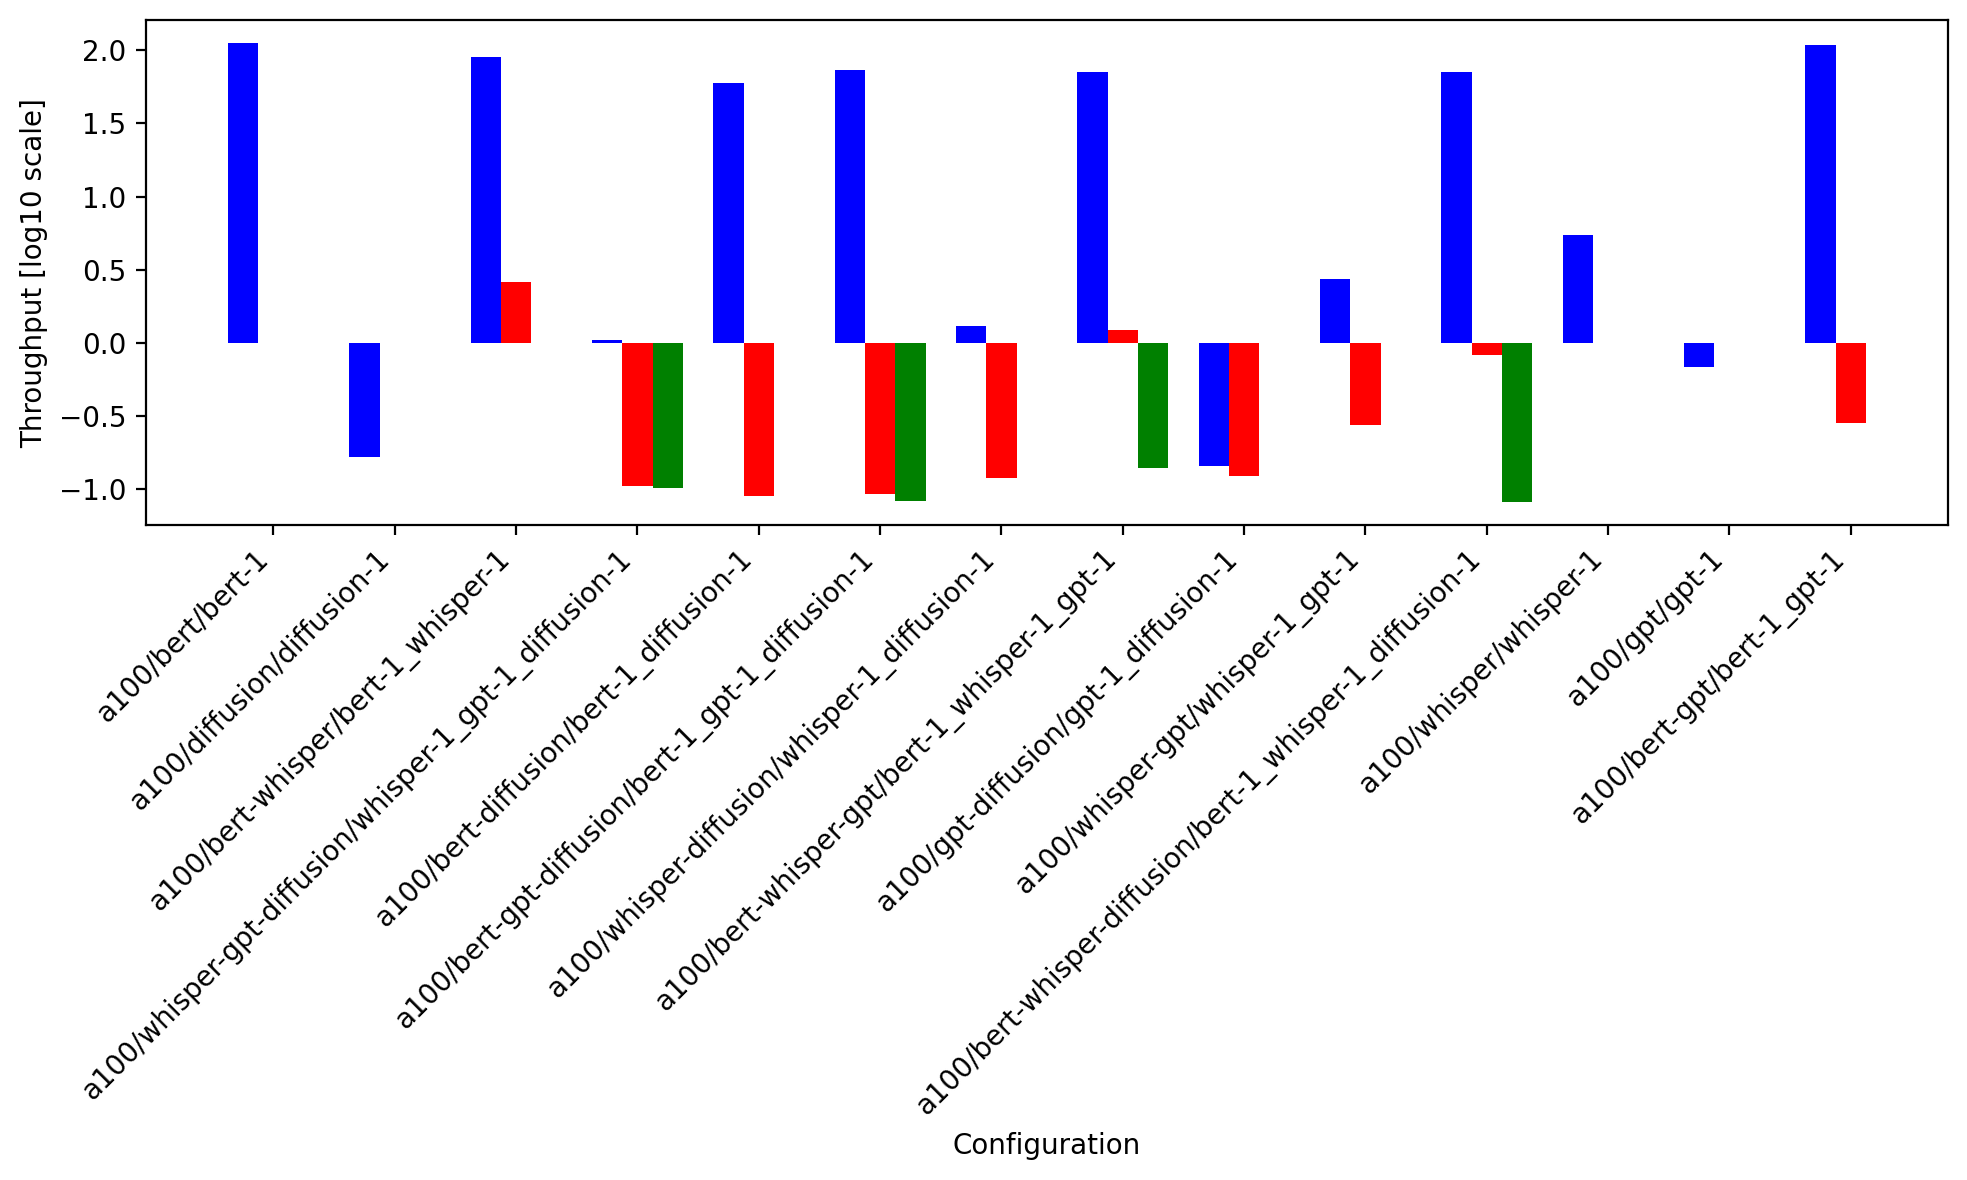

In [6]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
width = 0.25 
x = np.arange(len(dataset['configuration'][11:]))  # the label locations
ax.bar(x - width, np.log10(dataset['throughput'][11:, 0]), width, label='First model', color='blue')
ax.bar(x, np.log10(dataset['throughput'][11:, 1]), width, label='Second model', color='red')
ax.bar(x + width, np.log10(dataset['throughput'][11:, 2]), width, label='Third model', color='green')
ax.set_ylabel('Throughput [log10 scale]')
ax.set_xlabel('Configuration')
ax.set_xticks(x)
ax.set_xticklabels(dataset['configuration'][11:])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [7]:
dataset[8]

{'configuration': '4090/whisper/whisper-1',
 'energy': 50062.65,
 'latency_stats': array([[147.67981,       nan,       nan],
        [148.4537 ,       nan,       nan],
        [148.75386,       nan,       nan],
        [149.49918,       nan,       nan]], dtype=float32),
 'throughput': array([6.735472,      nan,      nan], dtype=float32)}

In [8]:
dataset[8]['energy']/60*5*dataset[8]['throughput'][0]

28099.632287377124

In [9]:
dataset[1]

{'configuration': '4090/diffusion/diffusion-1',
 'energy': 117172.67000000001,
 'latency_stats': array([[6451.6167,       nan,       nan],
        [6488.6816,       nan,       nan],
        [6493.894 ,       nan,       nan],
        [6498.4053,       nan,       nan]], dtype=float32),
 'throughput': array([0.15416047,        nan,        nan], dtype=float32)}

In [10]:
dataset[1]['energy']/(60*5*dataset[1]['throughput'][0])

2533.564974524879

In [11]:
dataset[4]

{'configuration': '4090/whisper-diffusion/whisper-1_diffusion-1',
 'energy': 99458.08999999998,
 'latency_stats': array([[ 313.99084, 8472.864  ,        nan],
        [ 661.3469 , 8914.3    ,        nan],
        [ 661.6535 , 8919.03   ,        nan],
        [ 668.3569 , 8932.018  ,        nan]], dtype=float32),
 'throughput': array([1.5691258 , 0.11233146,        nan], dtype=float32)}

In [12]:
dataset[4]['energy']/(60*5*dataset[4]['throughput'])

array([ 211.28133, 2951.328  ,        nan], dtype=float32)

In [13]:
60*5*dataset[4]['throughput']

array([470.73773,  33.69944,       nan], dtype=float32)

In [14]:
24.90584598894556*470+ 2668.4519099649374*33.69944

101631.08264755322

In [15]:
dataset[0]

{'configuration': '4090/bert/bert-1',
 'energy': 58244.06,
 'latency_stats': array([[4.584074 ,       nan,       nan],
        [4.6949387,       nan,       nan],
        [4.7311783,       nan,       nan],
        [6.08325  ,       nan,       nan]], dtype=float32),
 'throughput': array([212.69666,       nan,       nan], dtype=float32)}

In [16]:
dataset[0]['energy']/(60*5*dataset[0]['throughput'][0])

0.9127875867021806

In [17]:
dataset[8]

{'configuration': '4090/whisper/whisper-1',
 'energy': 50062.65,
 'latency_stats': array([[147.67981,       nan,       nan],
        [148.4537 ,       nan,       nan],
        [148.75386,       nan,       nan],
        [149.49918,       nan,       nan]], dtype=float32),
 'throughput': array([6.735472,      nan,      nan], dtype=float32)}

In [18]:
dataset[8]['energy']/(60*5*dataset[8]['throughput'][0])

24.775620028984854

In [19]:
dataset[2]

{'configuration': '4090/bert-whisper/bert-1_whisper-1',
 'energy': 61749.369999999995,
 'latency_stats': array([[  4.7957897, 247.607    ,         nan],
        [  7.7068806, 257.48706  ,         nan],
        [  7.856369 , 258.02588  ,         nan],
        [  8.622408 , 259.02557  ,         nan]], dtype=float32),
 'throughput': array([132.05147  ,   3.8839812,         nan], dtype=float32)}

In [20]:
60*5*dataset[2]['throughput']

array([39615.44  ,  1165.1943,        nan], dtype=float32)

In [21]:
39615.44*0.9167798137178886 + 1165.1943*24.90584598894556

65338.78548654943